In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import noisereduce as nr
from tqdm import tqdm
from scipy import signal
import skimage

/home/emmanuel/Documents/JUPYTER/phdenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import scipy

In [4]:
scipy.__version__

'1.11.3'

In [9]:
class Spectrogram_and_mfcc_extraction:

    def __init__(self, path_audio_files, path_segment_data, path_save_spec_arrays, cutoff, nyq_fr, sample_rate):
        self.path_audio_files = path_audio_files # path to audio files
        self.path_segment_data = path_segment_data # path to segment annotations
        self.path_save_spec_arrays = path_save_spec_arrays # path to save spectrogram numpy arrays
        self.cutoff = cutoff # cutoff frequency
        self.nyq_fr = nyq_fr # Nyquist rate
        self.sample_rate = sample_rate

    def read_audio_file(self, audio_file):
        """Read an audio file:
        INPUT: path to the audio file
        OUTPUT: audio signal (amplitudes) and the original sampling rate"""
        signal = librosa.load(self.path_audio_files+audio_file, sr = self.sample_rate)[0]
        return signal

    def reduce_noise(self, signal):
        """Reduce noise in the audio file 
        INPUT: audio signal and its sample rate
        OUTPUT: audio signal with reduced noise
        """
        # For further details see the source: https://github.com/timsainb/noisereduce
        reduced_noise = nr.reduce_noise(y = signal, sr = self.sample_rate)
        return reduced_noise

    def butter_lowpass(self, cutoff, nyq_freq, order=4):
        normal_cutoff = float(cutoff) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass')
        return b, a

    def butter_lowpass_filter(self, data, cutoff_freq, nyq_freq, order=4):
        """The low-pass filter allows low-frequency signal (from 0 Hz to a cutoff frequency) to pass through
        and attenuates high-frequency signals.
        
        INPUT: *data* the signal, *cutoff_freq* cutoff frequency that separates the range of frequencies that are passed through 
        from those that are attenuated or blocked, and *nyq_freq* the Nyquist rate is defined as twice the highest frequency present
        in the signal.
        OUTPU: *y* filtered signal
        """
        # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
        b, a = self.butter_lowpass(cutoff_freq, nyq_freq, order=order)
        y = signal.filtfilt(b, a, data)
        return y
    
    def preprocess_audio_file(self, audio_file):
        signal = self.read_audio_file(audio_file)
        reduced_noise = self.reduce_noise(signal)
        filtered_signal = self.butter_lowpass_filter(reduced_noise, self.cutoff, self.nyq_fr)
        return filtered_signal
        
    def read_segment_data(self):
        """Read the segment annotation data"""
        df =  pd.read_csv(self.path_segment_data)
        audio_segment_st_end = list((audio,segment,start,end) for segment, ID, start, end, _, _, audio in df.to_records(index=False))
        return audio_segment_st_end

    def audio2_segment_indexes(self):
        """Map each audio file to its corresponding segments and their start and end points"""
        
        audio_segment_st_end = self.read_segment_data()
        audio2data = {}
        
        for data in audio_segment_st_end:
            audio, segment, st, end = data
            if audio not in audio2data: audio2data[audio] = [(segment,st,end)]
            else: audio2data[audio].append((segment,st,end))
        return audio2data

    def audio_frame_to_mel_spectrogram(self, audio_frame, **kwargs):
        """Extract spectrograms from a given signal.
        INPUT: audio signal
        OUTPUT: spectrogram"""
        mel_spectrogram = librosa.feature.melspectrogram(y = audio_frame.astype(np.float32),**kwargs)
        return mel_spectrogram


    def segment_mfccs(self, segment_sig):
        """Extract MFCCs from a given signal.
        INPUT: signal and required parameters
        *segment_sig* audio signal
        *self.new_sr* sample rate
        *n_mfccs* number of mfccs to retain
        *n_mels* number of mels bins (filter bands)
        *fmin* minimum frequency to be detected
        *fmax* maximum frequency to be detected
        *n_fft* size of the window when applying STFT
        *hop_length* number of samples to skip between consecutive windows"""
        
        mfccs = librosa.feature.mfcc(y = segment_sig,sr = self.sample_rate,n_mfcc=20,n_mels = 128,fmin = 4000,fmax = 8000,
                                     n_fft = 1024,hop_length = 256)
        # Average MFCC matrices to get vectors that can be handled by conventional machine learning algorithms
        # use both means and standard deviations
        means = mfccs.mean(axis = 1)
        stdvs = mfccs.std(axis = 1)
        # concatenate the means and standard deviations
        total = np.hstack([means, stdvs])
        return total
        

                
    def Execution(self, **kwargs):
        
        odio2data = self.audio2_segment_indexes()
        
        segment_2_mfccs = {}

        for audio, data in tqdm(odio2data.items()):
            normalized_signal = self.preprocess_audio_file(audio)
            for segment_data in data:
                name, st, end = segment_data
                segment = normalized_signal[st:end]
                ## Extract mel specs spectrograms
                mel_spec = self.audio_frame_to_mel_spectrogram(segment,**kwargs)
                ## uncomment the following line if you want to use log spectrograms
                # log_spec = librosa.core.power_to_db(mel_spec)
                np.save(self.path_save_spec_arrays + name + ".npy", mel_spec)
                mfccs = self.segment_mfccs(segment)
                segment_2_mfccs[name] = mfccs
                
        mfcc_names = np.array(["x" + str(i) for i in range(40)])
        df = pd.DataFrame.from_dict(segment_2_mfccs, orient = 'index',columns = mfcc_names )
        df = df.rename_axis('Segment')
        df.to_csv("mfcc_data.csv", index = True)
        return df
       
                

In [10]:
p_odio = "../segment_index_extraction/audio_files/"
p_anno = "../segment_index_extraction/segment_data.csv"
p_arra = "spectrogram_arrays/"
cutoff = 20000
nyq_fr = 22050

In [11]:
WINDOW_LENGTH= 1024 # size of the window when applying STFT
HOPE_LENGTH = 256   # number of samples to jump between two consecutive windows
NUMBER_MELS = 128  # mels bins, this will be the HEIGHT of the mel spectrogram
SAMPLE_RATE = 44100 # sample rate used to down-sample the audio file
POWER = 1            # power of order 1, order i.e. squared energy
F_MIN = 4000       # minimum frequency to be detected
F_MAX  = 8000        # maximum frequency to be detected

In [12]:
PARAMETERS = {"n_fft":WINDOW_LENGTH,
              "hop_length":HOPE_LENGTH,
              "n_mels":NUMBER_MELS,
              "sr":SAMPLE_RATE,
              "power":POWER,
              "fmin":F_MIN,
              "fmax":F_MAX
             }

In [13]:
cricket = Spectrogram_and_mfcc_extraction(p_odio, p_anno, p_arra, cutoff, nyq_fr, SAMPLE_RATE)

In [14]:
df = cricket.Execution(**PARAMETERS)

100%|█████████████████████████████████████████████| 7/7 [00:34<00:00,  4.97s/it]


In [15]:
# MFCC feature vectors
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
Segment,,,,,,,,,,,,,,,,,,,,,
LPL11_0,-659.178692,11.360773,-100.875628,-32.991699,12.218294,7.131187,-0.208722,0.041040,10.111773,-2.061136,...,13.689325,9.884755,8.634281,7.260385,5.573074,4.974104,5.455871,6.287422,4.098062,4.282584
LPL11_1,-653.690964,15.041187,-104.587554,-34.627407,18.486887,7.543780,-2.688173,0.352494,9.296351,0.009718,...,13.957386,8.957835,9.604022,7.364448,5.397244,4.606577,5.593880,6.038195,4.896220,4.109360
LPL11_2,-648.773768,14.182398,-106.855792,-39.415343,16.702083,8.436958,-4.315072,-0.001731,10.301702,0.349981,...,14.518492,9.137887,10.344641,7.822855,5.667700,6.039401,6.048488,6.930764,4.892206,4.477969
LPL11_3,-652.500947,14.656759,-95.300659,-38.159206,14.813690,6.126138,-6.006142,-1.000835,10.859177,-0.015872,...,14.528523,8.711125,9.388678,7.473229,5.496835,5.635712,5.802447,5.924468,4.675734,3.719726
LPL11_4,-604.968553,13.238533,-91.084611,-32.099084,22.529538,4.741744,-5.615496,2.224811,5.896679,0.495323,...,13.926790,8.409327,8.291843,7.557728,4.346290,5.604617,5.256945,5.003708,4.629745,3.497240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RBB13_355,-696.650996,9.991257,-101.229509,-24.941295,20.535131,3.144014,-3.635341,11.587410,-4.538424,-2.456307,...,11.126233,7.284441,9.160107,7.788354,6.367706,6.885316,4.199335,5.331018,4.982587,4.550687
RBB13_356,-683.088591,8.476870,-101.609309,-24.763718,21.539069,4.290248,-2.475294,11.676165,-4.599551,-1.307782,...,9.771630,7.778904,9.194758,7.045340,5.997198,6.762374,5.593045,5.425227,3.946362,4.169075
RBB13_357,-695.289680,8.838180,-98.387164,-28.814698,20.436850,5.888271,-8.150035,13.959081,-2.010329,-2.105191,...,11.620167,7.751468,9.772874,6.663511,6.208115,6.344865,6.408479,5.700693,4.489311,4.345156


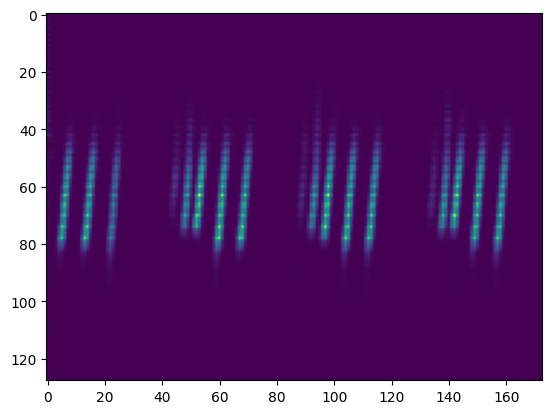

In [10]:
# Display mel spectrogram examples
imgs = os.listdir(p_arra)
img = np.load(p_arra+imgs[2])
plt.imshow(img)